In [1]:
#pip install xgboost
#!pip install dtreeviz
#!pip install optuna
#!pip install tensorflow

In [2]:
# Genearal usage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import scipy.stats as stats
import copy
import itertools
import math
import warnings

# Linear models
from sklearn import linear_model
from statsmodels.formula.api import ols

# model preparation and evaluation
from sklearn.metrics import mean_absolute_percentage_error

# XGBoost
import xgboost as xgb
from dtreeviz.trees import *
from sklearn import model_selection
import optuna

# LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#Ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

<img src="raw/bikeProblem.png" width="600" height="500">

Load test and test data (See Bike_EDA_PreProcessing.ipynb for details)

In [3]:
X_train = pd.read_excel('raw/X_train.xlsx')
y_train = pd.read_excel('raw/y_train.xlsx')
X_train_c = pd.read_excel('raw/X_train_c.xlsx')
y_train_c = pd.read_excel('raw/y_train_c.xlsx')
X_train_r = pd.read_excel('raw/X_train_r.xlsx')
y_train_r = pd.read_excel('raw/y_train_r.xlsx')

X_test = pd.read_excel('raw/X_test.xlsx')
y_test = pd.read_excel('raw/y_test.xlsx')
X_test_c = pd.read_excel('raw/X_test_c.xlsx')
y_test_c = pd.read_excel('raw/y_test_c.xlsx')
X_test_r = pd.read_excel('raw/X_test_r.xlsx')
y_test_r = pd.read_excel('raw/y_test_r.xlsx')

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Develop at least two different models and train them on the training set. Find a proper way to combine prediction results of these model. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) XGBoost

Training Steps:
['temp', 'hum', 'weathersit', 'workingday', 'season', 'yr', 'hr']
1. Predict 'casual' using ['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']
2. Predict 'register' using ['temp', 'hum', 'season', 'yr', 'hr']
3. Add 1. 2. together to derive the predicted 'cnt'
4. Predict 'cnt' using  ['temp', 'hum', 'hr', 'yr', 'season'] to ensemble with the other model and to assess the performance comparison to the model generated in 3..

1.1) Predict 'casual'

In [4]:
# reduce the feature to the selected ones.
X_train_c = X_train_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]
X_test_c = X_test_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]

In [5]:
y_train_c.set_index('datetime', inplace = True)
y_test_c.set_index('datetime', inplace = True)

In [6]:
model_xgb_c = xgb.XGBRegressor()

def objective(trial):
    
    #hyperparameter searching
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    model_xgb_c.set_params(**params)
    #CV config
    score = model_selection.cross_val_score(model_xgb_c,
                                            X_train_c,
                                            y_train_c,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [7]:
# Searching for the optimal hyperparameter
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print(f"The best parameters are : \n {study.best_params}")

[I 2024-03-23 10:14:34,370] A new study created in memory with name: no-name-acab19fb-5d6a-4d7b-b7be-63904f09e85b
C:\Users\Ryo\AppData\Local\Temp\ipykernel_14276\753032069.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-03-23 10:14:48,403] Trial 0 finished with value: 2293.5107797140313 and parameters: {'max_depth': 8, 'n_estimators': 591, 'learning_rate': 1.1409443275493445e-08}. Best is trial 0 with value: 2293.5107797140313.
[I 2024-03-23 10:14:50,373] Trial 1 finished with value: 570.9523110790866 and parameters: {'max_depth': 3, 'n_estimators': 618, 'learning_rate': 0.2749500114669415}. Best is trial 1 with value: 570.9523110790866.
[I 2024-03-23 10:14:50,658] Trial 2 finished with value: 2293.3670642963 and parameters: {'max_depth': 3, 'n_estimators': 21, 'learning_rate': 2.9216155949011424e-06}. Best is trial 1

The best parameters are : 
 {'max_depth': 5, 'n_estimators': 761, 'learning_rate': 0.010757630954546672}


In [8]:
model_xgb_c = xgb.XGBRegressor(**study.best_params)
model_xgb_c.fit(X_train_c.values, y_train_c.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010757630954546672,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=761, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
importance = pd.DataFrame(zip(X_train_c.columns,
                              model_xgb_c.feature_importances_),
                              columns=["Features","Importance"])
importance = importance.sort_values("Importance",
                                    ascending=False)
importance

,Features,Importance
3,workingday,0.366065
5,hr,0.260344
0,temp,0.185964
4,yr,0.127610
1,hum,0.038404
2,weathersit,0.021613


<Axes: xlabel='Features'>

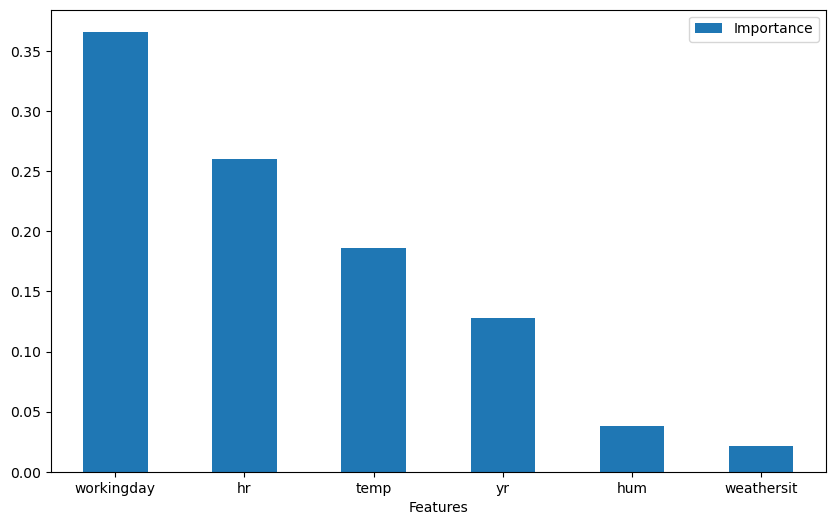

In [10]:
importance.plot.bar(x = 'Features',
                    y = 'Importance', 
                    rot=0, figsize=(10, 6))

In [11]:
# prediction
train_pred_c = model_xgb_c.predict(X_train_c.values)
test_pred_c = model_xgb_c.predict(X_test_c.values)

# predicted result
train_MAPE_xgb_c = mean_absolute_percentage_error(y_train_c, train_pred_c)
test_MAPE_xgb_c = mean_absolute_percentage_error(y_test_c, test_pred_c)

print('train MAPE: ', train_MAPE_xgb_c)
print('test MAPE: ', test_MAPE_xgb_c)

train MAPE:  839412741342798.4
test MAPE:  649903348136613.2


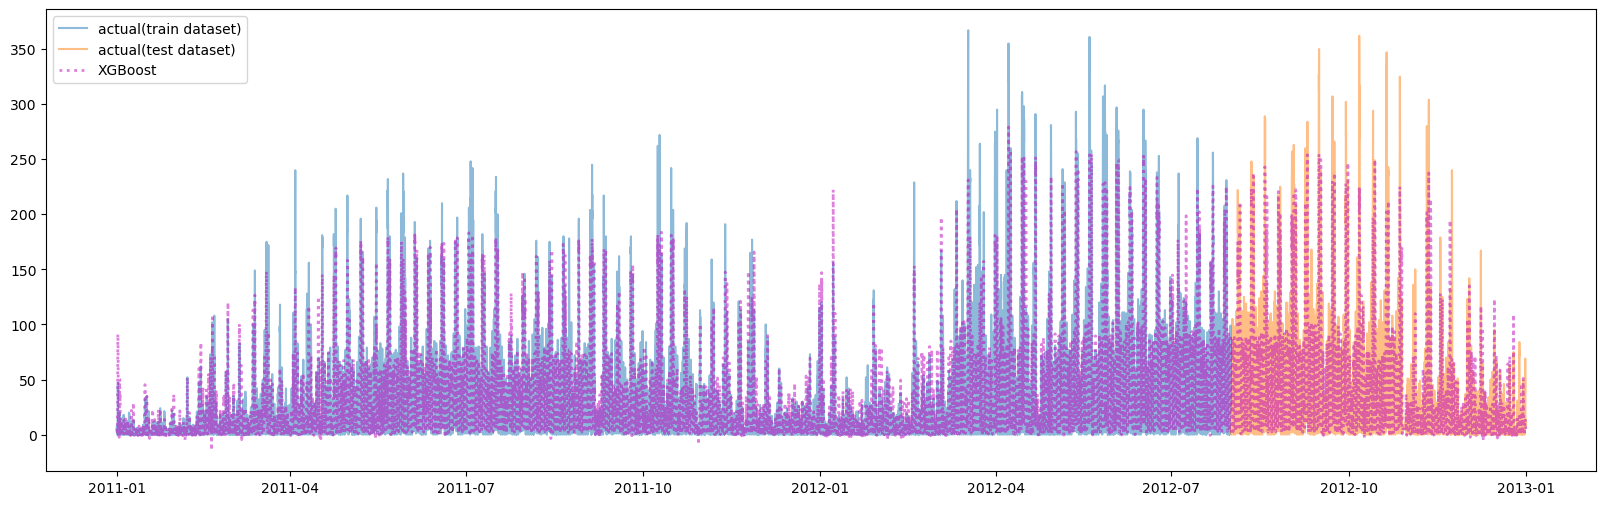

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train_c.index, y_train_c.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test_c.index, y_test_c.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train_c.index, train_pred_c, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test_c.index, test_pred_c, label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [13]:
y_test_c.head()

,casual
datetime,
2012-08-01 00:00:00,3
2012-08-01 01:00:00,5
2012-08-01 02:00:00,0
2012-08-01 03:00:00,0
2012-08-01 04:00:00,1


In [14]:
xgb_result_c = pd.DataFrame({'actual' : y_test_c.values.flatten(),
                              'pred' : test_pred_c.flatten()})
print(xgb_result_c.describe())

            actual         pred
count  3632.000000  3632.000000
mean     42.887390    41.185081
std      55.980942    50.785782
min       0.000000    -5.186035
25%       5.000000     5.941355
50%      22.000000    21.144361
75%      61.000000    61.049530
max     362.000000   254.712540


1.2) Predict 'registered'

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Explore the data through descriptive statistics and visualization and summarize your findings about the data. </h>
<hr style="border-top: 0.5px solid #b;">